# Deep AutoEncoders as Pre-Training for Image Classifiers

This network demonstrates the usage of a deep autoencoder for pre-training of an image classifier. The reduction of trraining time and the quality of the results are compared.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

## Load the MNIST Dataset

In [12]:
data = fetch_openml('mnist_784', data_home='./data/mnist/')

In [83]:
X = data['data']
y = data['target']

print("Loaded overall {} images with {} features per image.".format(X.shape[0], X.shape[1]))

Loaded overall 70000 images with 784 features per image.


## Prepare the data

The data is normalized by the maximum pixel value. This step could by using the Keras `ImageDataGenerator` class.

In [84]:
# Normalize the data
X = X.astype('float32') / 255.

## Train/Test Split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [87]:
print("Woring with {} training images and {} test images.".format(len(X_train), len(X_test)))

Woring with 52500 training images and 17500 test images.


## Deep Denoising Autoencoder

In this section, first a deep denoising autoencoder is built and trained. A production model is initialized that does not add Gaussian noise and uses the weights derived during training of the first model.


### Define and train the deep denoising autoencoder

In [89]:
def get_denoising_autoencoder(training=True):
    """
    Returns a deep denoising autoencoder model.
    INPUT:
        training (boolean): if true, Gaussian noise is applied.
    OUTPUT:
        encoder: Keras model for the encoder
        autoencoder: Keras model for the autoencoder
    """
    n_inputs = 28 * 28 # MNIST
    encoding_dim_1 = 300
    encoding_dim_2 = 150
    decoding_dim_1 = encoding_dim_2
    decoding_dim_2 = encoding_dim_1

    # Input layer
    inputs = layers.Input(shape=(n_inputs,))

    # Add a Gaussian Noise Layer
    inputs_noisy = layers.GaussianNoise(stddev=0.1)(inputs, training=training)

    # Build the Encoder
    encoded_1 = layers.Dense(encoding_dim_1, activation='relu')(inputs_noisy) # 784 -> 300
    encoded_2 = layers.Dense(encoding_dim_2, activation='relu')(encoded_1) # 300 -> 150

    # Build the Decoder
    decoded_1 = layers.Dense(encoding_dim_1, activation='relu')(encoded_2) # 150 -> 300
    decoded_2 = layers.Dense(n_inputs, activation='relu')(decoded_1) # 300 -> 784

    # Define the Models
    autoencoder = keras.Model(inputs, decoded_2)
    encoder = keras.Model(inputs, encoded_2)
    
    return encoder, autoencoder

#### Create the autoencoder model for training

In [90]:
encoder, autoencoder = get_denoising_autoencoder(training=True)

In [91]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_21 (Dense)             (None, 150)               45150     
_________________________________________________________________
dense_22 (Dense)             (None, 300)               45300     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               235984    
Total params: 561,934
Trainable params: 561,934
Non-trainable params: 0
_____________________________________________________

In [34]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               45150     
Total params: 280,650
Trainable params: 280,650
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compile the model

opt = keras.optimizers.Adadelta(learning_rate=0.01)
autoencoder.compile(optimizer='Adam',
                      loss='MSE')

In [36]:
# Early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=2,
                                  verbose=0, mode='auto')

# Train the model
history = autoencoder.fit(X_train,
                    X_train,
                    validation_data=(X_test, X_test),
                    callbacks=[es],
                    shuffle=True,
                    epochs=20,
                    batch_size=256)

Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 4s 84us/sample - loss: 0.0270 - val_loss: 0.0141
Epoch 2/20
52500/52500 [==============================] - 4s 70us/sample - loss: 0.0114 - val_loss: 0.0107
Epoch 3/20
52500/52500 [==============================] - 4s 73us/sample - loss: 0.0096 - val_loss: 0.0097
Epoch 4/20
52500/52500 [==============================] - 4s 73us/sample - loss: 0.0087 - val_loss: 0.0091
Epoch 5/20
52500/52500 [==============================] - 4s 74us/sample - loss: 0.0083 - val_loss: 0.0085
Epoch 6/20
52500/52500 [==============================] - 4s 75us/sample - loss: 0.0080 - val_loss: 0.0086
Epoch 7/20
52500/52500 [==============================] - 4s 75us/sample - loss: 0.0077 - val_loss: 0.0079
Epoch 8/20
52500/52500 [==============================] - 4s 78us/sample - loss: 0.0075 - val_loss: 0.0079
Epoch 9/20
52500/52500 [==============================] - 4s 76us/sample - loss: 0.0074 - val_

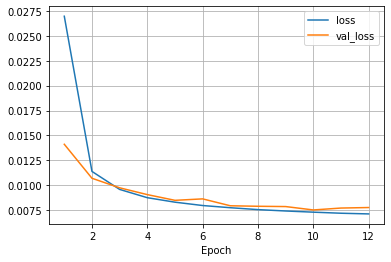

In [103]:
# Plot the training curve
n_epochs = len(history.history['loss'])

plt.plot(range(1,n_epochs+1), history.history['loss'], label='loss')
plt.plot(range(1,n_epochs+1), history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

In [95]:
history.history['val_loss']

[0.014108482998822416,
 0.010695718221792152,
 0.009737696454993316,
 0.009054875775533064,
 0.008479869813365596,
 0.008625181156183992,
 0.00793350370994636,
 0.007883210266700812,
 0.007853799852515969,
 0.007513558263438088,
 0.0077044659667781425,
 0.0077568745344877245]

In [37]:
keras.models.save_model(autoencoder, './models/autoencoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/autoencoder/assets


In [38]:
keras.models.save_model(encoder, './models/encoder')

INFO:tensorflow:Assets written to: ./models/encoder/assets


#### Visualize the reconstruction error on the trained model

Here, the Gaussian Noise is still turned on.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

In [76]:
def plot_results(y_trues, y_preds):
    """
    Creates a plot to compare the original and the reconstructed image.
    INPUT:
        y_trues: array of 28x28 original MNIST images
        y_preds: array of 28x28 reconstructed MNIST images
    OUTPUT:
        NONE:
    """
    assert len(y_trues) == len(y_preds)

    fig = plt.figure(figsize=(20,3))
    columns = len(y_preds)
    rows = 2

    
    # Plot ground truth images
    for i, img in enumerate(y_trues):
        fig.add_subplot(rows, columns, 1+i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
    # Plot predicted images
    for j, img in enumerate(y_preds):
        fig.add_subplot(rows, columns, 1+len(y_trues) + j)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.show()

In [74]:
n_predictions = 20

y_preds = autoencoder.predict(X_train[:n_predictions]).reshape((-1,28,28))
y_trues = X_train[:n_predictions].reshape((-1,28,28))

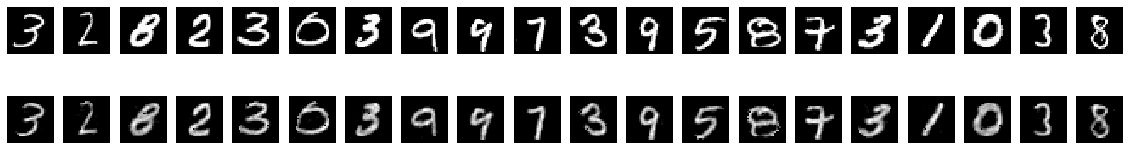

In [75]:
plot_results(y_trues, y_preds)

### Create the encoder model without Gaussian noise

This model will be used by the image classifier.

In [80]:
# Create a new instance of the encoder with turned off Gaussian noise
prod_encoder, prod_autoencoder = get_denoising_autoencoder(training=False)

# Copy the weights from the trained encoder
prod_encoder.set_weights(encoder.get_weights())
prod_autoencoder.set_weights(autoencoder.get_weights())

# Print a summary
prod_encoder.summary()
prod_autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_17 (Dense)             (None, 150)               45150     
Total params: 280,650
Trainable params: 280,650
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
____________________________________

Create predictions with the productive deep autoencoder (Gaussian noise turned off).

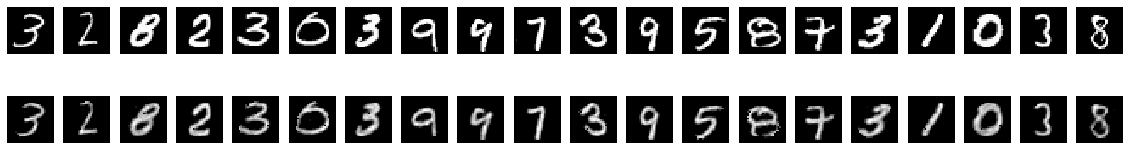

In [81]:
n_predictions = 20

y_preds = prod_autoencoder.predict(X_train[:n_predictions]).reshape((-1,28,28))
y_trues = X_train[:n_predictions].reshape((-1,28,28))

plot_results(y_trues, y_preds)

Obviously, the images loose sharpness when being reconstructed by the autoencoder.